In [2]:
import IPython
import pandas as pd
import numpy as np
import datetime
import pickle
import sklearn
import seaborn as sn

# used to access folder structures
import os

# used to open images
import PIL

# Graphs, visualizations
import matplotlib.pyplot
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
# For Image Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras import layers
from keras.optimizers import Adam, SGD


from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



In [4]:
# Import Data From Pickle file

with open('y.pickle', 'rb') as f:
    y_data = pickle.load(f)
f.close()
with open('X.pickle', 'rb') as f:
    X_data = pickle.load(f)
f.close()

In [5]:
#Train-validation-test split

# train test split for validation after training x_test is never touched or looked at during training
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(np.asarray(X_data),
                                                                       np.asarray(y_data),
                                                                       test_size=.2,
                                                                       random_state=42)

# train test split for validation during training
x_train,x_val,y_train,y_val=sklearn.model_selection.train_test_split(x_train,
                                                                     y_train,
                                                                     test_size=.25,
                                                                     random_state=42)

#Dimension of the kaggle dataset & percentage of negative patches
print(x_train.shape,y_train.shape, 1-sum(y_train)/y_train.shape[0])
print(x_test.shape,y_test.shape, 1-sum(y_test)/y_test.shape[0])
print(x_val.shape,y_val.shape, 1-sum(y_val)/y_val.shape[0])

input_shape=x_train.shape[1:]
input_shape

(166514, 50, 50, 3) (166514,) 0.7144444310988866
(55505, 50, 50, 3) (55505,) 0.7182415998558689
(55505, 50, 50, 3) (55505,) 0.7189802720475633


(50, 50, 3)

In [6]:
def acc_plot(history):
    plt.plot(history.history['accuracy'], alpha=.6)
    plt.plot(history.history['val_accuracy'], alpha=.6)
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    return plt

def loss_plot(history):
    plt.plot(history.history['loss'][1:], alpha=.6)
    plt.plot(history.history['val_loss'], alpha=.6)
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper left')
    return plt
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
def conf_matrix(model, x_test, y_test):
    
    y_pred = [1 * (x[0]>=0.5) for x in model.predict(x_test)]

    matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(matrix, index = [i for i in ['No Cancer (actual)', 'Cancer (actual)']],
                      columns = [i for i in ['predict No Cancer', 'predict Cancer']])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='d')
    return plt

def acc_df(histories):
    columns = ['model size' ,'loss', 'accuracy', 'val_loss', 'val_accuracy']
    df = pd.DataFrame(columns = columns)
    for history in histories:
    
    # get the epoch with the highest validation accuracy for each history element
        i = 0
        index = 0
        comp = 0
        for val_acc in history.history['val_accuracy']:
            if val_acc > comp:
                comp = val_acc
                i = index
            index += 1

        df_temp = pd.DataFrame([[history.model.name,
                                  history.history['loss'][i],
                                  history.history['accuracy'][i],
                                  history.history['val_loss'][i],
                                  history.history['val_accuracy'][i]]], 
                        columns = columns)
        df = df.append(df_temp)

    df = df.set_index('model size')

    df = df.style.format({
        'loss': '{:,.2f}'.format,
        'accuracy': '{:,.2%}'.format,
        'val_loss': '{:,.2f}'.format,
        'val_accuracy': '{:,.2%}'.format,
    })

    return df

def plot_accuracies(histories, lower_ylim=.7, upper_ylim=.9, alpha=.6, **kwargs):
    for history in histories:
        plt.plot(history.history['accuracy'], alpha=alpha)

    plt.xlabel('epoch')
    plt.ylim([lower_ylim,upper_ylim])
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()

    for history in histories:
        plt.plot(history.history['val_accuracy'], alpha=alpha)

    plt.xlabel('epoch')
    plt.ylim([lower_ylim,upper_ylim])
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()
    

### Callbacks ###

#Early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, verbose=2,
                                      mode='max', baseline=None, restore_best_weights=True)

mcp_save = keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

#Learning Rate Annealer
lrr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.1,
                       patience=20,
                       min_lr=1e-4,
                       verbose=2)

In [7]:
# lower the number of epochs
epochs = 150

total = np.asarray(y_data).shape[0]
pos = sum(np.asarray(y_data))
neg = total - pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)

weight_for_0 = (1 / neg) * total
weight_for_1 = (1 / pos) * total

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.40
Weight for class 1: 3.52


<h1>Simple Convolutional Network</h1>

<p> From the dense network notebook we learned, that the learning rate of 0.001 was a good learning rate for the adam optimizer to take for the dense network. The simple convolutional network contain only 1 convolutional layer and a simple dense layer. In the there is only a convolutional layer a a maxpool layer. The activation function for the convolutional layer is ReLu.</p>

In [7]:
epochs = 100
histories0 = []
batch_size = 1024

In [8]:
name="1-layer-64-cnn-without-normalization"
model0 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size = (5, 5), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    
    ],name=name
)


model0.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories0.append(
    model0.fit(
        x_train, 
        y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(x_val,y_val), 
        callbacks=[lrr, es], 
        class_weight=class_weight))


#############################################################################

1301/1301 [==============================] - 22s 15ms/step - loss: 20.3664 - accuracy: 0.6770 - val_loss: 0.4752 - val_accuracy: 0.7979


<p>The second simple CNN is build similar to the first one. One difference is that there will the a batch normalization after the convolutional layer.</p>

In [9]:
epochs = 100
batch_size = 1024

In [10]:
name="1-layer-64-cnn-with-normalization"
model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size = (5, 5), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    
    ],name=name
)


model1.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories0.append(
    model1.fit(
        x_train, 
        y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(x_val,y_val), 
        callbacks=[lrr, es], 
        class_weight=class_weight))


#############################################################################

1301/1301 [==============================] - 28s 22ms/step - loss: 1.0308 - accuracy: 0.7927 - val_loss: 0.5168 - val_accuracy: 0.8104


In [11]:
acc_df(histories0)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-64-cnn-without-normalization,4.07,74.64%,0.48,79.79%
1-layer-64-cnn-with-normalization,0.89,80.87%,0.52,81.04%


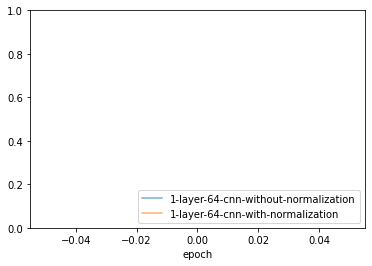

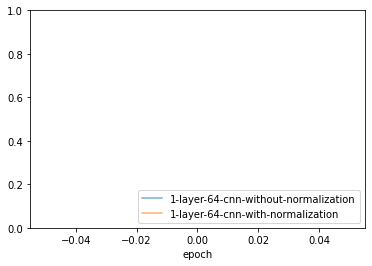

In [12]:
plot_accuracies(histories0, lower_ylim=0, upper_ylim=1)

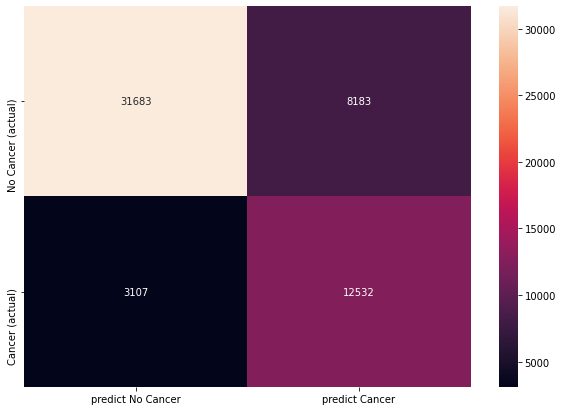

In [13]:
# plot confuction matrix
plt=conf_matrix(model0, x_test, y_test)
plt.show()

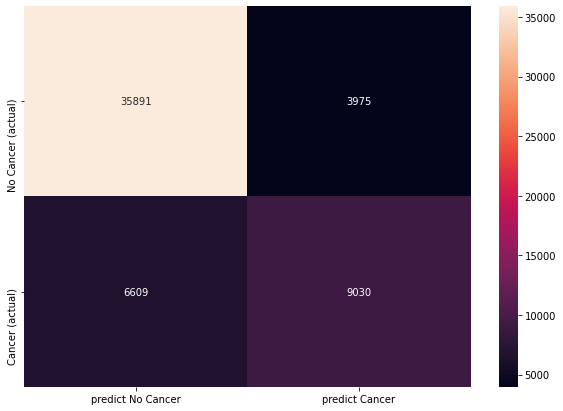

In [14]:
# plot confuction matrix
plt=conf_matrix(model1, x_test, y_test)
plt.show()

<h1> Advanced CNN </h1>

<p>This CNN is an advanced verson of the CNN. The first CNN contains 2 convolutional layers. Each layer gets batch normalized and before the flattening there is also a max pooling layer.</p>

In [9]:
histories1 = []


epochs = 100
batch_size = 1024

name="2-layer-128-64-cnn-with-normalization"
model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(128, kernel_size = (5, 5), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size = (5, 5), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    
    ],name=name
)

model2.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories1.append(
    model2.fit(
        x_train, 
        y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(x_val,y_val), 
        callbacks=[lrr, es], 
        class_weight=class_weight))



2602/2602 [==============================] - 164s 62ms/step - loss: 2.2271 - accuracy: 0.7827 - val_loss: 0.7731 - val_accuracy: 0.7790


In [10]:
epochs = 100
batch_size = 1024

name="1-layer-512-cnn-with-normalization-dropout"
model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(512,kernel_size=(5,5),activation='relu'),
        layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        layers.MaxPooling2D(pool_size=(2,2)),
        
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    
    ],name=name
)

model3.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories1.append(
    model3.fit(
        x_train, 
        y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(x_val,y_val), 
        callbacks=[lrr, es], 
        class_weight=class_weight))

2602/2602 [==============================] - 327s 125ms/step - loss: 2.5032 - accuracy: 0.7889 - val_loss: 1.5954 - val_accuracy: 0.6159


In [14]:
batch_size = 1024
epochs = 100

########################################################################

name="2-layer-128-64-cnn-with-normalization-dropout"
model4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(128,kernel_size=(5,5),activation='relu'),
        layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        layers.Conv2D(64,kernel_size=(5,5),activation='relu'),
        layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        layers.MaxPooling2D(pool_size=(2,2)),

        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')   
    
    ],name=name
)


model4.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.0001), metrics=["accuracy"])

histories1.append(model4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))


 139/1301 [==>...........................] - ETA: 2:14 - loss: 0.7537 - accuracy: 0.6355

KeyboardInterrupt: 

In [ ]:
acc_df(histories1)

In [ ]:
plot_accuracies(histories1, lower_ylim=0, upper_ylim=1)

In [ ]:
# plot confuction matrix
plt=conf_matrix(model2, x_test, y_test)
plt.show()

In [ ]:
# plot confuction matrix
plt=conf_matrix(model3, x_test, y_test)
plt.show()

In [ ]:
# plot confuction matrix
plt=conf_matrix(model4, x_test, y_test)
plt.show()

RUN TILL HERE

<h1> Learnings </h1>

<p>Testtesttest </p>

<h1>Advanced CNN with optimized dense layer</h1>

In [ ]:
batch_size = 64
epochs = 100
histories2 = []

name="adv-cnn-dense-1"
model5 = keras.Sequential(
    [
        ################# to be replaced ###############################
        keras.Input(shape=input_shape),
        layers.Conv2D(64,kernel_size=(5,5),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64,kernel_size=(5,5),activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        
        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        #################################################################

        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')   
    
    ],name=name
)

model5.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.0001), metrics=["accuracy"])

histories2.append(model5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))


########################################################################

########################################################################



In [ ]:
acc_df(histories1)